In [1]:
"""

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import seaborn as sns

os.environ["PROJ_LIB"] = "/opt/miniconda3/envs/aspen-fire/share/proj"

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the grid stats
fp = os.path.join(projdir,'data/tabular/mod/gridstats_tm_lf.csv')
gs = pd.read_csv(fp)

# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grids = gpd.read_file(fp)

# create a unique ID
grids['grid_idx'] = grids['Fire_ID'].astype(str) + grids['grid_index'].astype(str)
grids['grid_idx'] = grids['grid_idx'].astype(int)

# subset to keep processed grid cells
grids = grids[grids['grid_idx'].isin(gs['grid_idx'].unique())]
print(f"\nThere are [{len(grids)}] grids across [{len(grids['Fire_ID'].unique())}] fires.\n")
print(grids.columns)


There are [46016] grids across [76] fires.

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_first_day', 'frp_first_night',
       'Fire_ID', 'Fire_Name', 'n_grids', 'geometry', 'grid_idx'],
      dtype='object')


In [3]:
# tidy the grid cell data
grids["day_prop"] = np.where(
    grids["afd_count"] > 0,
    grids["day_count"] / grids["afd_count"],
    0   # or 0, depending on what you want
)
# make the data frame smaller ...
grids = grids[[
    'grid_idx','frp_csum','afd_count','day_prop','unique_days','overlap',
    'first_obs_date','last_obs_date','dt_max_frp','Fire_ID', 'Fire_Name',
    'geometry'
]]

# tidy some of the column names
grids.rename(columns={
    'Fire_Name': 'fire_name',
    'Fire_ID': 'fire_id',
}, inplace=True)

# add in x,y coordinates
df = grids.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grids = grids.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grids.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grids.duplicated(subset=['grid_idx']).sum()}] duplicate grids.\n")
grids = grids.drop_duplicates(subset=['grid_idx'], keep='first')


Index(['grid_idx', 'frp_csum', 'afd_count', 'day_prop', 'unique_days',
       'overlap', 'first_obs_date', 'last_obs_date', 'dt_max_frp', 'fire_id',
       'fire_name', 'geometry', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



In [4]:
# join in the treemap / landfire summary data
grids = pd.merge(grids, gs, on='grid_idx', how='left')
grids.columns

Index(['grid_idx', 'frp_csum', 'afd_count', 'day_prop', 'unique_days',
       'overlap', 'first_obs_date', 'last_obs_date', 'dt_max_frp', 'fire_id',
       'fire_name', 'geometry', 'x', 'y', 'species_gp', 'tm_id_n', 'ba_live',
       'tpa_live', 'hdr_live', 'qmd_live', 'ba_dead', 'tpa_dead',
       'ba_live_sum', 'ba_live_pr', 'tpa_live_sum', 'tpa_live_pr', 'H_ba',
       'H_tpa', 'fortypnm_gp', 'fortypcd_pct', 'cc', 'cbd', 'forest_prop'],
      dtype='object')

In [5]:
# join in the aspen patch metrics
fp = os.path.join(projdir,'data/tabular/mod/gridstats_aspen_patches.csv')
aspen_patches = pd.read_csv(fp)
aspen_patches.drop(columns=['Unnamed: 0', 'grid_ha'], inplace=True)

# merge with the dataframe, fill NA
patch_cols = ['n_patch', 'mean_patch', 'large_patch', 'total_aspen_ha', 'aspen_pr']
grids = pd.merge(grids, aspen_patches, on='grid_idx', how='left')
grids[patch_cols] = grids[patch_cols].fillna(0) # fill na with 0 (no aspen)
grids.columns

Index(['grid_idx', 'frp_csum', 'afd_count', 'day_prop', 'unique_days',
       'overlap', 'first_obs_date', 'last_obs_date', 'dt_max_frp', 'fire_id',
       'fire_name', 'geometry', 'x', 'y', 'species_gp', 'tm_id_n', 'ba_live',
       'tpa_live', 'hdr_live', 'qmd_live', 'ba_dead', 'tpa_dead',
       'ba_live_sum', 'ba_live_pr', 'tpa_live_sum', 'tpa_live_pr', 'H_ba',
       'H_tpa', 'fortypnm_gp', 'fortypcd_pct', 'cc', 'cbd', 'forest_prop',
       'n_patch', 'mean_patch', 'large_patch', 'total_aspen_ha', 'aspen_pr'],
      dtype='object')

In [6]:
# join in the topography metrics
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_topo_v2.csv')
topo = pd.read_csv(fp)
# create the unique ID
topo['grid_idx'] = topo['Fire_ID'].astype(str) + topo['grid_index'].astype(str)
print(f"\n{topo.columns}\n")

# merge the topography to the grid
topo['grid_idx'] = topo['grid_idx'].astype(int)
topo = topo[['grid_idx', 'elevation', 'northness', 'eastness', 'slope', 'chili', 'tpi']]
grids = grids.merge(topo, on='grid_idx', how='left')
print(f"\n{grids.columns}\n")


Index(['system:index', 'Fire_ID', 'chili', 'eastness', 'elevation',
       'grid_index', 'northness', 'slope', 'tpi', '.geo', 'grid_idx'],
      dtype='object')


Index(['grid_idx', 'frp_csum', 'afd_count', 'day_prop', 'unique_days',
       'overlap', 'first_obs_date', 'last_obs_date', 'dt_max_frp', 'fire_id',
       'fire_name', 'geometry', 'x', 'y', 'species_gp', 'tm_id_n', 'ba_live',
       'tpa_live', 'hdr_live', 'qmd_live', 'ba_dead', 'tpa_dead',
       'ba_live_sum', 'ba_live_pr', 'tpa_live_sum', 'tpa_live_pr', 'H_ba',
       'H_tpa', 'fortypnm_gp', 'fortypcd_pct', 'cc', 'cbd', 'forest_prop',
       'n_patch', 'mean_patch', 'large_patch', 'total_aspen_ha', 'aspen_pr',
       'elevation', 'northness', 'eastness', 'slope', 'chili', 'tpi'],
      dtype='object')



In [10]:
# fire weather (gridmet) - VPD, ERC, VS
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_gridmet_full_v2.csv')
weather = pd.read_csv(fp)
weather.drop(columns=['.geo','system:index'], inplace=True)
print(f"\n{weather.columns}\n")

# load the fire climatology (15-year average ERC)
climate = pd.read_csv(os.path.join(projdir,'data/earth-engine/exports/fire_clim_fc.csv'))
climate.drop(columns=['.geo','system:index'], inplace=True)

# merge in the climatology
weather_climate = pd.merge(weather, climate, on='Fire_ID', how='left')
# calculate the deviation from long-term average ERC
weather_climate['erc_mn_dv'] = weather_climate['erc_mn'] - weather_climate['erc_clim_fire']
weather_climate.head(10)

# tidy and merge the climate/topo
weather_climate.rename(columns={
    'first_obs': 'first_obs_date',
    'last_obs': 'last_obs_date'
}, inplace=True) # for joining to the grid data

weather_climate.rename(columns={'Fire_ID': 'fire_id'}, inplace=True)
weather_climate['fire_id'] = weather_climate['fire_id'].astype(str) # to match the grid column

# merge climate to the grid by fire id and first acquisition day
grids['first_obs_date'] = grids['first_obs_date'].astype(str) # to match gee output
grids['last_obs_date'] = grids['last_obs_date'].astype(str) # to match gee output

grids = grids.merge(weather_climate, on=['fire_id','first_obs_date','last_obs_date'], how='left')
grids.columns


Index(['Fire_ID', 'erc_mn', 'first_obs', 'last_obs', 'vpd_97', 'vs_mx'], dtype='object')



Index(['grid_idx', 'frp_csum', 'afd_count', 'day_prop', 'unique_days',
       'overlap', 'first_obs_date', 'last_obs_date', 'dt_max_frp', 'fire_id',
       'fire_name', 'geometry', 'x', 'y', 'species_gp', 'tm_id_n', 'ba_live',
       'tpa_live', 'hdr_live', 'qmd_live', 'ba_dead', 'tpa_dead',
       'ba_live_sum', 'ba_live_pr', 'tpa_live_sum', 'tpa_live_pr', 'H_ba',
       'H_tpa', 'fortypnm_gp', 'fortypcd_pct', 'cc', 'cbd', 'forest_prop',
       'n_patch', 'mean_patch', 'large_patch', 'total_aspen_ha', 'aspen_pr',
       'elevation', 'northness', 'eastness', 'slope', 'chili', 'tpi', 'erc_mn',
       'vpd_97', 'vs_mx', 'erc_clim_fire', 'erc_mn_dv'],
      dtype='object')

### Merge in the Composite Burn Index summary

In [11]:
# load the CBI data
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_cbibc_forest_v2.csv')
sev = pd.read_csv(fp)
sev.drop(columns=['system:index','.geo'], inplace=True)
# create a unique ID
sev['grid_idx'] = sev['Fire_ID'].astype(str) + sev['grid_index'].astype(str)
print(sev.columns)

Index(['Fire_ID', 'grid_index', 'mean', 'p90', 'p95', 'p97', 'p99', 'stdDev',
       'grid_idx'],
      dtype='object')


In [12]:
# Rename the columns for clarity
cols = ['mean', 'p90', 'p95', 'p97', 'p99', 'stdDev']
for col in cols:
    new_name = 'cbibc_' + col
    sev.rename(columns={col: new_name}, inplace=True)
sev.drop(columns=['Fire_ID','grid_index'], inplace=True)
sev['grid_idx'] = sev['grid_idx'].astype(int)
# merge the dataframes
grids = grids.merge(sev, on='grid_idx', how='left')
# drop any grids with NA CBI
grids = grids[~grids['cbibc_p97'].isna()]
print(len(grids))
grids[['grid_idx','species_gp','frp_csum','cbibc_mean',
        'cbibc_p90','cbibc_p95','cbibc_p97','cbibc_p99']].head(10)

198337


,grid_idx,species_gp,frp_csum,cbibc_mean,cbibc_p90,cbibc_p95,cbibc_p97,cbibc_p99
0,161955422,douglas-fir,19.031477,0.005552,0.00,0.03,0.05,0.26
1,161955422,lodgepole pine,19.031477,0.005552,0.00,0.03,0.05,0.26
2,161955422,pinon-juniper,19.031477,0.005552,0.00,0.03,0.05,0.26
3,161955422,ponderosa pine,19.031477,0.005552,0.00,0.03,0.05,0.26
4,161955422,quaking aspen,19.031477,0.005552,0.00,0.03,0.05,0.26
5,161955422,white fir,19.031477,0.005552,0.00,0.03,0.05,0.26
6,161957669,douglas-fir,11.357204,0.081248,0.18,0.65,0.90,1.69
7,161957669,ponderosa pine,11.357204,0.081248,0.18,0.65,0.90,1.69
8,161957669,quaking aspen,11.357204,0.081248,0.18,0.65,0.90,1.69
9,161957669,spruce-fir,11.357204,0.081248,0.18,0.65,0.90,1.69


In [13]:
def get_dom_sp(df, value_col, out_col):
    """
    Find dominant species per grid_idx based on the specified value_col
    """
    agg = (
        df.groupby(['grid_idx', 'species_gp'], as_index=False)[value_col].sum()
    )
    dom = (
        agg.loc[agg.groupby('grid_idx')[value_col].idxmax()]
        .rename(columns={'species_gp': out_col})
        [['grid_idx', out_col]]
    )
    return dom

# Example: one for BALIVE and one for TPA
dom_ba  = get_dom_sp(grids, value_col='ba_live', out_col='dom_sp_ba')
dom_tpa = get_dom_sp(grids, value_col='tpa_live',    out_col='dom_sp_tpa')

# Merge both into grid summary
grids = (
    grids
    .merge(dom_ba, on='grid_idx', how='left')
    .merge(dom_tpa, on='grid_idx', how='left')
)
grids[['grid_idx','species_gp','dom_sp_ba','dom_sp_tpa']].head()

,grid_idx,species_gp,dom_sp_ba,dom_sp_tpa
0,161955422,douglas-fir,ponderosa pine,ponderosa pine
1,161955422,lodgepole pine,ponderosa pine,ponderosa pine
2,161955422,pinon-juniper,ponderosa pine,ponderosa pine
3,161955422,ponderosa pine,ponderosa pine,ponderosa pine
4,161955422,quaking aspen,ponderosa pine,ponderosa pine


In [14]:
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_model_data.csv')
grids.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_model_data.csv


### Make some plots of the data

[Text(0.5, 0, 'log(cFRP)'), Text(0.5, 1.0, 'Distribution of cFRP')]

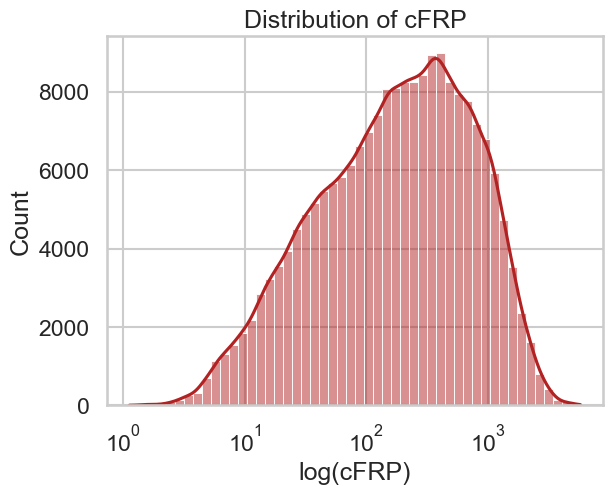

In [15]:
# plot the distribution of the response variables
# Filter to valid (positive) FRP and non-null CBIbc values
df_plot = grids[(grids['frp_csum'] > 0) & (grids['cbibc_mean'].notna())]

# Set plot style
sns.set(style="whitegrid", context="talk")

# --- Plot log-scaled FRP ---
sns.histplot(
    data=df_plot,
    x='frp_csum',
    log_scale=True,
    kde=True,
    bins=50,
    color='firebrick'
).set(
    xlabel='log(cFRP)',
    title='Distribution of cFRP'
)

0
0


[Text(0.5, 0, 'CBIbc'), Text(0.5, 1.0, 'Distribution of CBIbc (mean)')]

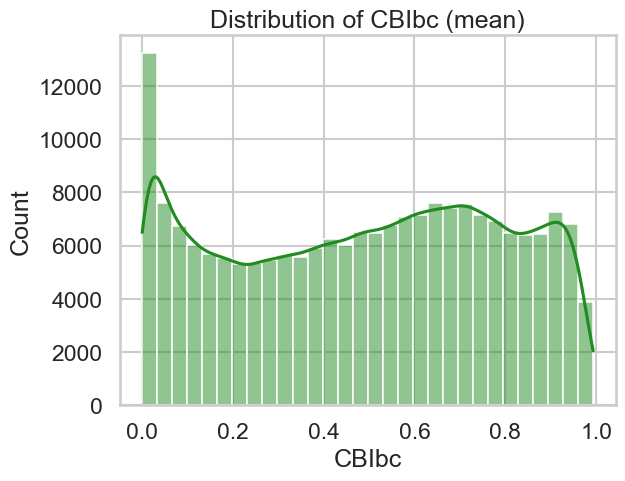

In [16]:
# bound CBI to a beta distribution
df_plot['cbibc_sc'] = (df_plot['cbibc_mean'] + 1e-4) / (3 + 2 * 1e-4)
print((df_plot['cbibc_sc'] <= 0).sum())
print((df_plot['cbibc_sc'] >= 1).sum())

sns.histplot(
    data=df_plot,
    x='cbibc_sc',
    kde=True,
    bins=30,
    color='forestgreen'
).set(
    xlabel='CBIbc',
    title='Distribution of CBIbc (mean)'
)

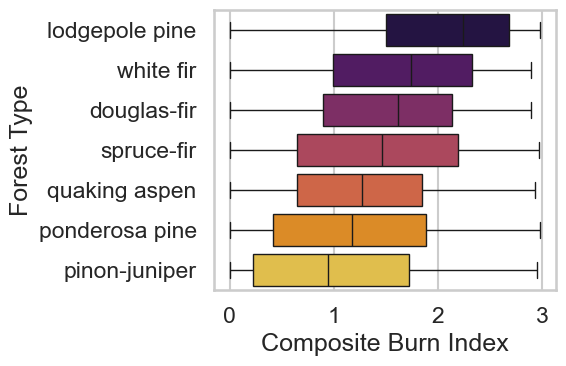


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_dom_sp_tpa_cbibc_p97.png



In [17]:
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = grids.groupby('fortypnm_gp')['cbibc_mean'].median().sort_values(ascending=False)
ordered = med.index.tolist()

# plot it
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=grids,
    x='cbibc_mean',
    y='fortypnm_gp',
    order=ordered,
    palette='inferno',
    dodge=False)

# plt.xscale('log') # log-scale FRP
plt.xlabel('Composite Burn Index')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_dom_sp_tpa_cbibc_p97.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

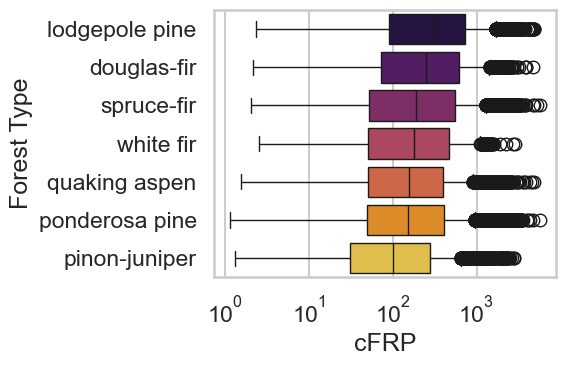


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_dom_sp_tpa_cfrp.png



In [18]:
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
df = grids.drop_duplicates(subset=['grid_idx'], keep='first')
med = df.groupby('fortypnm_gp')['frp_csum'].median().sort_values(ascending=False)
ordered = med.index.tolist()

# plot it
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=df,
    x='frp_csum',
    y='fortypnm_gp',
    order=ordered,
    palette='inferno',
    dodge=False)

plt.xscale('log') # log-scale FRP
plt.xlabel('cFRP')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_dom_sp_tpa_cfrp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

<Axes: xlabel='mean_patch', ylabel='cbibc_mean'>

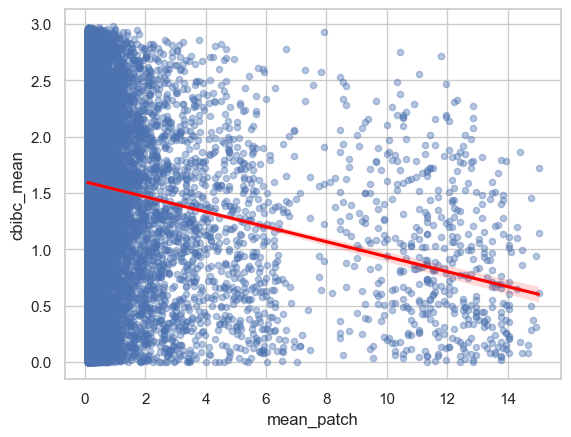

In [19]:
grids_aspen = grids[grids['mean_patch'] > 0]
grids_aspen = grids_aspen.drop_duplicates(subset='grid_idx')

# create quartile bins
grids_aspen['patch_bin'] = pd.qcut(grids_aspen['mean_patch'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Set Seaborn theme (optional)
sns.set(style="whitegrid")

# Create the regression plot
sns.regplot(
    data=grids_aspen,
    x='mean_patch',
    y='cbibc_mean',
    scatter_kws={'alpha': 0.4, 's': 20},
    line_kws={'color': 'red'},
    ci=95
)

In [20]:
grids_aspen['mean_patch'].describe(percentiles=np.arange(0.1, 1.0, 0.02))

count    24667.000000
mean         0.726925
std          1.784657
min          0.090000
10%          0.090000
12%          0.090000
14%          0.090000
16%          0.090000
18%          0.090000
20%          0.105000
22%          0.112500
24%          0.120000
26%          0.120000
28%          0.128957
30%          0.135000
32%          0.135000
34%          0.144000
36%          0.150000
38%          0.157500
40%          0.169412
42%          0.180000
44%          0.180000
46%          0.180000
48%          0.192857
50%          0.202500
50%          0.202500
52%          0.216000
54%          0.225000
56%          0.240000
58%          0.255000
60%          0.270000
62%          0.281250
64%          0.304615
66%          0.330000
68%          0.360000
70%          0.378000
72%          0.414000
74%          0.450000
76%          0.495000
78%          0.540000
80%          0.617143
82%          0.702000
84%          0.810000
86%          0.951429
88%          1.144286
90%       

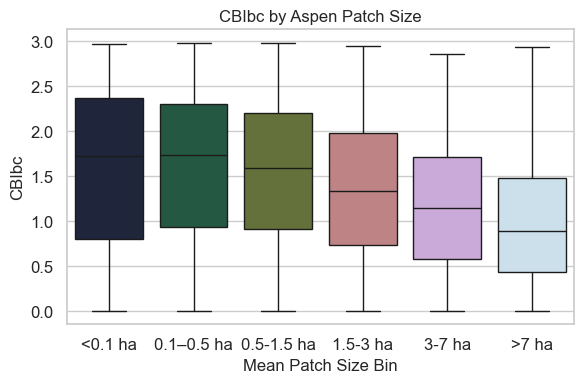

In [21]:
# Set bins manually based on the percentiles
bins = [0, 0.1, 0.5, 1.5, 3.0, 7.0, np.inf]
labels = ['<0.1 ha', '0.1–0.5 ha', '0.5-1.5 ha', '1.5-3 ha', '3-7 ha', '>7 ha']

grids_aspen['patch_bin_q'] = pd.cut(
    grids_aspen['mean_patch'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# plot it
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=grids_aspen,
    x='patch_bin_q',
    y='cbibc_mean',
    palette='cubehelix'
).set(
    xlabel='Mean Patch Size Bin',
    ylabel='CBIbc',
    title='CBIbc by Aspen Patch Size'
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

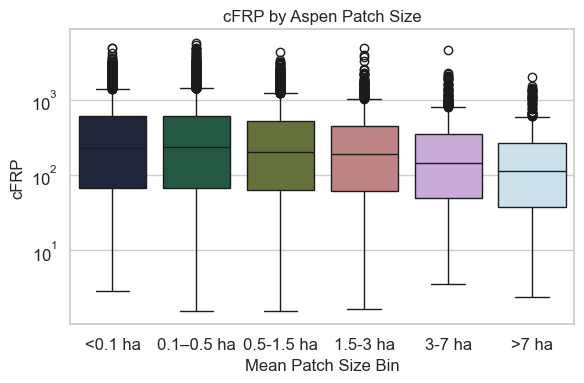

In [22]:
# same for cFRP
# plot it
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=grids_aspen,
    x='patch_bin_q',
    y='frp_csum',
    palette='cubehelix'
).set(
    xlabel='Mean Patch Size Bin',
    ylabel='cFRP',
    title='cFRP by Aspen Patch Size'
)
plt.yscale('log') # log-scale FRP

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()